<div class="alert alert-block alert-info">
<b>Deadline:</b> April 5, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Neural machine translation with transformers.

The goal of this exerscise is to get familiar with a transformer model, which was introduced in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf).

We base our code on the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post.
Module `transformer.py` contains some useful modules from that blog post. We recommend you to use those modules when we state so in the description.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import transformer as tr
import tools

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

We use the same translation dataset as in the RNN exercise.

In [7]:
# Translation data
from data import TranslationDataset, SOS_token, EOS_token, MAX_LENGTH
trainset = TranslationDataset(data_dir, train=True)

src_seq, tgt_seq = trainset[np.random.choice(len(trainset))]
print('Source sentence:')
print(' as word indices: ', src_seq)
print(' as string: ', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_seq))

print('Target sentence:')
print(' as word indices: ', tgt_seq)
print(' as string: ', ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_seq))

100.0%


Extracting ../data\translation_data.zip to ../data
Source sentence:
 as word indices:  tensor([  6, 298,  11, 948, 247, 121,  31,   5,   1])
 as string:  je ne suis simplement pas tres occupee . EOS
Target sentence:
 as word indices:  tensor([  2,   3, 395, 148, 304,  19,   4,   1])
 as string:  i m just not very busy . EOS


## Custom DataLoader

Next we prepare a custom data loader which puts sequences of varying lengths in one tensor. We do so by using a custom `collate_fn` (see the description of the `collate_fn` argument of [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Our collate function combines source sequences in one tensor `src_seqs` with extra values (at the end) filled with `PADDING_VALUE=0`. To tell the transformer which elements are padded, we also need to compute the mask `src_mask`.

The function also combines target sequences in one tensor `tgt_seqs` but it does it a bit differently:
* The resulting tensor is of shape `(max_tgt_seq_length+1, batch_size)`, where `max_tgt_seq_length` is the length of the longest target sequence in the mini-batch.
* The first element of each sequence in the resulting tensor is `SOS_token`.
* The remaining elements are filled similarly to the source sequences with extra values (at the end) filled with `PADDING_VALUE=0`.

We will use tensor `tgt_seqs[:-1]` as inputs of the transformer decoder and `tgt_seqs[1:]` as the targets for the model (decoder) outputs. The `SOS_token` is needed to predict the first word in the output sequence in the corresponding (first) location of the decoder output.

Your task is to implement this function.

In [8]:
PADDING_VALUE = 0

In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_seq):
          src_seq is of shape (src_seq_length)
          tgt_seq is of shape (tgt_seq_length)

    Returns:
      src_seqs of shape (max_src_seq_length, batch_size): LongTensor of padded source sequences.
      src_mask of shape (max_src_seq_length, batch_size): BoolTensor (tensor with boolean elements) indicating which
          elements of the src_seqs tensor should be ignored in computations: True values in src_mask correspond
          to padding values in src_seqs.
      tgt_seqs of shape (max_tgt_seq_length+1, batch_size): LongTensor of padded target sequences.
    """
    # YOUR CODE HERE
    # Get src_seq, tgt_seq, batch_size.
    batch_size = len(list_of_samples)  
    src_seq, tgt_seq = [a for a, b in list_of_samples], [b for a, b in list_of_samples]
    
    # src_seqs preparation
    src_seqs = pad_sequence(src_seq, batch_first=True)
    src_seqs = torch.transpose(src_seqs, 0, 1)
    
    # Generate src_mask
    pad_token_id = 0
    src_mask = ~(src_seqs != pad_token_id)
    
    # tgt_seqs preparation
    tgt_seqs = pad_sequence(tgt_seq, batch_first=True)
    tgt_seqs = torch.transpose(tgt_seqs, 0, 1)
    
    SOS_seqs = torch.zeros([1,batch_size]).long()
    tgt_seqs = torch.cat((SOS_seqs, tgt_seqs), 0)
    
    # Print and check result
#     print(SOS_seqs)
#     print(src_seqs)
#     print(src_mask)
#     print(tgt_seqs)
    
    return src_seqs, src_mask, tgt_seqs
    raise NotImplementedError()

In [10]:
def test_collate_shapes():
    pairs = [
        (torch.LongTensor([2, EOS_token]), torch.LongTensor([3, 4, EOS_token])),
        (torch.LongTensor([6, 7, EOS_token]), torch.LongTensor([9, EOS_token])),
    ]
    src_seqs, src_mask, tgt_seqs = collate(pairs)
    assert src_seqs.dtype == torch.long, f"Wrong src_seqs.dtype: {src_seqs.dtype}"
    assert src_seqs.shape == torch.Size([3, 2]), f"Wrong src_seqs.shape: {src_seqs.shape}"

    assert tgt_seqs.dtype == torch.long, f"Wrong tgt_seqs.dtype: {tgt_seqs.dtype}"
    assert tgt_seqs.shape == torch.Size([4, 2]), f"Wrong tgt_seqs.shape: {tgt_seqs.shape}"
    assert (tgt_seqs[0] == torch.empty(2, dtype=torch.long).fill_(SOS_token)).all(), "Target sequences should start with SOS_token."
    
    assert src_mask.dtype == torch.bool, f"Wrong src_mask.dtype: {src_mask.dtype}"
    assert src_mask.shape == src_seqs.shape, f"Wrong src_mask.shape: {src_mask.shape}"
    print('Success')

test_collate_shapes()

Success


In [11]:
# This cell tests collate()
def test_collate():
    pairs = [
        (torch.LongTensor([2, EOS_token]), torch.LongTensor([3, 4, EOS_token])),
        (torch.LongTensor([6, 7, EOS_token]), torch.LongTensor([9, EOS_token])),
    ]
    src_seqs, src_mask, tgt_seqs = collate(pairs)
    #src_seqs, src_mask, tgt_seqs = src_seqs[:, [1, 0]], src_mask[:, [1, 0]], tgt_seqs[:, [1, 0]]
    print('src_seqs:\n', src_seqs)
    print('src_mask:\n', src_mask)
    print('tgt_seqs:\n', tgt_seqs)
    expected_src_seqs = torch.tensor([
        [2,         6],
        [EOS_token, 7],
        [0,         EOS_token]
    ])
    expected_src_mask = torch.tensor([
        [False, False],
        [False, False],
        [ True, False]
    ])
    expected_tgt_seqs = torch.tensor([
        [0,         0],
        [3,         9],
        [4,         EOS_token],
        [EOS_token, 0]
    ])
    
    assert ((
        (src_seqs == expected_src_seqs).all()
         and (src_mask == expected_src_mask).all()
         and (tgt_seqs == expected_tgt_seqs).all()
        ) or (
        (src_seqs == expected_src_seqs[:, [1, 0]]).all()
         and (src_mask == expected_src_mask[:, [1, 0]]).all()
         and (tgt_seqs == expected_tgt_seqs[:, [1, 0]]).all()
        )
    ), "Wrong outputs of collate."
    print('Success')

test_collate()

src_seqs:
 tensor([[2, 6],
        [1, 7],
        [0, 1]])
src_mask:
 tensor([[False, False],
        [False, False],
        [ True, False]])
tgt_seqs:
 tensor([[0, 0],
        [3, 9],
        [4, 1],
        [1, 0]])
Success


In [12]:
# We create custom DataLoader using the implemented collate function
# We are going to process 64 sequences at the same time (batch_size=64)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

In [13]:
# Create test set
testset = TranslationDataset(data_dir, train=False)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=False, collate_fn=collate)

# Transformer

## Encoder block

<img src="encoder_block.png" width=150 style="float: right;">

We first implement one block of the transformer encoder (see the figure on the right).
* We recommend you to use layers available in PyTorch:
  * [nn.LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
  * [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) to implement dropout
  * [nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

* `Feedforward` is simply an MLP processing each position (each element of the source sequence) independently. The exact implementation of the MLP is not tested in this notebook. We used an MLP with:
  * one hidden layer with `n_hidden` neurons
  * a dropout and ReLU activation after the hidden layer
  * an output layer with `n_features` outputs.

* In two places where skip connections are used, we apply dropout on the main path, combine the main path with the skip connection and then apply layer normalization. This order is slightly different to the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) code.

Hints:
* **We recommend you to test that the padded values of the input sequence do not affect the outputs in the positions that correspond to non-padded values.**

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and in two places on the main path (before
                   combining the main path with a skip connection).
        """
        # YOUR CODE HERE
        super(EncoderBlock, self).__init__()
        self.atten = nn.MultiheadAttention(n_features,n_heads)
        self.Drop1 = nn.Dropout(dropout)
        self.Norm1 = nn.LayerNorm(n_features)
        
        self.FeedFW = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(n_hidden, n_features),
        )
        
        self.Drop2 = nn.Dropout(dropout)
        self.Norm2 = nn.LayerNorm(n_features)
#         raise NotImplementedError()

    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size, n_features): Input sequences.
          mask of shape (max_seq_length, batch_size): BoolTensor indicating which elements of the input
              sequences should be ignored (True values correspond to ignored elements in x).
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequences.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        # YOUR CODE HERE
        atten_out, atten_out_para = self.atten(x,x,x, key_padding_mask=mask.T)
        h1 = self.Norm1(x + self.Drop1(atten_out))
        h2 = self.Norm2(h1 + self.Drop2(self.FeedFW(h1)))
    
        return h2
        raise NotImplementedError()

In [15]:
def test_EncoderBlock_shapes():
    encoder_block = EncoderBlock(n_features=16, n_heads=4, n_hidden=64)

    x = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

    mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (max_seq_length, batch_size)
    outputs = encoder_block(x, mask)
    assert outputs.shape == torch.Size([4, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_EncoderBlock_shapes()

Success


In [16]:
# This cell tests EncoderBlock
# Check that the signal does not propagate from the padded elements
import unittest.mock

def no_dropout(x, *args, **kwargs):
    return x

@unittest.mock.patch('torch.nn.functional.dropout', no_dropout)  # .eval() does not disable F.dropout()
def test_EncoderBlock():
    with torch.no_grad():
        encoder_block = EncoderBlock(n_features=16, n_heads=4, n_hidden=64)

        x = torch.tensor([
            [1, 2],
            [3, 4],
            [5, 0],
            [6, 0],
        ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

        mask = torch.tensor([
            [0, 0],
            [0, 0],
            [0, 1],
            [0, 1],
        ], dtype=torch.bool)  # (max_seq_length, batch_size)

        outputs1 = encoder_block(x, mask)
        print('outputs1[:2,1,:]:\n', outputs1[:2,1,:])

        # Modify non-padded values
        x[:2,1,:] = x[:2,1,:] + 1
        outputs2 = encoder_block(x, mask)
        print('outputs2[:2,1,:]:\n', outputs2[:2,1,:])
        diff = outputs2[:2,1,:] - outputs1[:2,1,:]
        assert torch.max(torch.abs(diff)) > 0, "Some elements of the source sequence do not affect the output."
        
        # Modify padded values
        x[2:,1,:] = x[2:,1,:] + 1
        outputs3 = encoder_block(x, mask)
        print('outputs3[:2,1,:]:\n', outputs3[:2,1,:])
        diff = outputs3[:2,1,:] - outputs2[:2,1,:]
        assert torch.max(torch.abs(diff)) == 0, "Padding values affect the output."
        
        print('Success')

test_EncoderBlock()

outputs1[:2,1,:]:
 tensor([[ 0.7251,  1.0947, -0.9299,  0.0873, -1.4959,  0.9428,  1.0644,  0.1036,
         -0.1536, -0.2214, -0.1482, -1.1030, -0.9451,  0.9837,  1.7240, -1.7288],
        [ 0.7038,  1.1184, -0.9396,  0.0364, -1.4688,  0.8427,  1.0909,  0.2256,
         -0.0928, -0.2232, -0.1432, -1.0722, -1.0134,  0.9518,  1.7381, -1.7545]])
outputs2[:2,1,:]:
 tensor([[ 0.7323,  1.0831, -0.9260,  0.1132, -1.5037,  0.9854,  1.0517,  0.0485,
         -0.1825, -0.2179, -0.1518, -1.1174, -0.9125,  0.9984,  1.7167, -1.7177],
        [ 0.7204,  1.0989, -0.9327,  0.0807, -1.4894,  0.9247,  1.0693,  0.1245,
         -0.1444, -0.2199, -0.1482, -1.0989, -0.9561,  0.9792,  1.7270, -1.7350]])
outputs3[:2,1,:]:
 tensor([[ 0.7323,  1.0831, -0.9260,  0.1132, -1.5037,  0.9854,  1.0517,  0.0485,
         -0.1825, -0.2179, -0.1518, -1.1174, -0.9125,  0.9984,  1.7167, -1.7177],
        [ 0.7204,  1.0989, -0.9327,  0.0807, -1.4894,  0.9247,  1.0693,  0.1245,
         -0.1444, -0.2199, -0.1482, -1.0989, 

<img src="encoder.png" width=200 style="float: right;">

## Encoder

The encoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding))
* Positional encoding (please use `tr.PositionalEncoding` from the attached module)
* `n_blocks` of the `EncoderBlock` modules.

Notes:
* Provided implementation of `tr.PositionalEncoding` is the same as in [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post. See the blog post for more detail.
* Our longest sequences have length `MAX_LENGTH`, this is the value that you can use when you specify `PositionalEncoding`.

In [17]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          src_vocab_size: Number of words in the source vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the encoder.
          n_heads: Number of attention heads inside the EncoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of EncoderBlock.
          dropout: Dropout level used in EncoderBlock.
        """
        # YOUR CODE HERE
        super(Encoder, self).__init__()
        self.Embed = nn.Embedding(src_vocab_size, n_features)
        self.PosEnc = tr.PositionalEncoding(n_features)
        self.EncBlocks = nn.ModuleList(
            [EncoderBlock(n_features=n_features, n_heads=n_heads, n_hidden=n_hidden, dropout=dropout) 
             for i in range(n_blocks)])
        
#         raise NotImplementedError()

    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size): LongTensor with the input sequences.
          mask of shape (max_seq_length, batch_size): BoolTensor indicating which elements should be ignored.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequences.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        # YOUR CODE HERE
        h1 = self.Embed(x)
        h2 = self.PosEnc(h1)
        y = h2
        for f in self.EncBlocks:
            y = f(y, mask)  
            
        return(y)
        raise NotImplementedError()

In [18]:
def test_Encoder_shapes():
    encoder = Encoder(src_vocab_size=10, n_blocks=1, n_features=16, n_heads=4, n_hidden=64)

    x = torch.tensor([
        [SOS_token,     SOS_token],
        [        3,             4],
        [        5,     EOS_token],
        [        6, PADDING_VALUE],
        [EOS_token, PADDING_VALUE],
    ])  # (max_seq_length, batch_size)

    mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (max_seq_length, batch_size)
    outputs = encoder(x, mask)
    assert outputs.shape == torch.Size([5, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_Encoder_shapes()

Success


# Decoding

## Subsequent mask

In the training loop, we will use target sequences (starting with `SOS_token`) as inputs of the decoder. By doing that, we make it possible for the decoder to use previously decoded words when predicting probabilities of the next word. This idea is similar to the way decoding was done in the RNN exercise. However, the computations are parallelized in the transformer decoder, and the probabilities of each word in the target sequence are produced by doing one pass through the decoder.

During decoding, we need to make sure that when we compute the probability of the next word, we only use preceding and not subsequent words. In transformers, this is done by providing a mask which tells which elements should be used or ignored when producing the output. The following function produces this kind of mask.

The $i$-th row in the produced mask says which of the input elements should be used to compute the $i$-th element of the output:
* `0`: the corresponding element of the input sequence can be used.
* `-inf`: the corresponding element of the input sequence cannot be used.

In [19]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


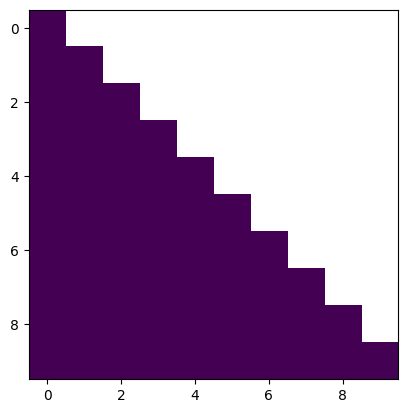

In [20]:
# This is a typical mask that we need to use while decoding
mask = subsequent_mask(10)
print(mask)
plt.imshow(mask)

<img src="decoder_block.png" width=150 style="float: right;">

## Decoder block

Next we implement one block of the transformer decoder (see the figure on the right).
* We recommend you to use layers available in PyTorch:
  * [nn.LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
  * [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) to implement dropout
  * [nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

* `Feedforward` is simply an MLP processing each position (each element of the source sequence) independently. The exact implementation of the MLP is not tested in this notebook. We used an MLP with:
  * one hidden layer with `n_hidden` neurons
  * a dropout and ReLU activation after the hidden layer
  * an output layer with `n_features` outputs.

* In three places where skip connections are used, we applied dropout on the main path, combined the main path with the skip connection and then applied layer normalization. This order is slightly different to the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) code.

Notes:
* The first attention block is self-attention when query, key and value inputs are same. The second attention block uses the encoded `z` values as keys and values, and the outputs of the previous layer as query.
* **We recommend you to test that the subsequent values of the input sequence do not affect the outputs.**

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and in three places on the main path (before
                   combining the main path with a skip connection).
        """
        # YOUR CODE HERE
        super(DecoderBlock, self).__init__()
        
        self.Atte1 = nn.MultiheadAttention(n_features,n_heads)
        self.Drop1 = nn.Dropout(dropout)
        self.Norm1 = nn.LayerNorm(n_features)
        
        self.Atte2 = nn.MultiheadAttention(n_features,n_heads)
        self.Drop2 = nn.Dropout(dropout)
        self.Norm2 = nn.LayerNorm(n_features)
        
        self.FeedFW = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(n_hidden, n_features),
        )
        self.Drop3 = nn.Dropout(dropout)
        self.Norm3 = nn.LayerNorm(n_features)
        
#         raise NotImplementedError()

    def forward(self, y, z, src_mask, tgt_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size, n_features): Transformed target sequences used as the inputs
              of the block.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (max_src_seq_length, batch_size): BoolTensor indicating which elements of the
             encoded source sequences should be ignored.
          tgt_mask of shape (max_tgt_seq_length, max_tgt_seq_length): Subsequent mask to ignore subsequent
             elements of the target sequences in the inputs. The rows of this matrix correspond to the output
             elements and the columns correspond to the input elements.
        
        Returns:
          out of shape (max_seq_length, batch_size, n_features): Output tensor.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        # YOUR CODE HERE
        atten_out1, atten_out_para1 = self.Atte1(y,y,y, attn_mask = tgt_mask)
        h1 = self.Norm1(y + self.Drop1(atten_out1))
        
        atten_out2, atten_out_para2 = self.Atte2(h1,z,z, key_padding_mask=src_mask.T)
        h2 = self.Norm2(h1 + self.Drop2(atten_out2))
        
        h3 = self.Norm3(h2 + self.Drop3(self.FeedFW(h2)))
        
        return (h3)
        raise NotImplementedError()

In [22]:
def test_DecoderBlock_shapes():
    decoder_block = DecoderBlock(n_features=16, n_heads=4, n_hidden=64)

    y = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

    z = torch.randn(4, 2, 16, requires_grad=True)  # (max_seq_length, batch_size, n_features)

    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (max_seq_length, batch_size)

    tgt_mask = subsequent_mask(y.size(0))

    outputs = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
    assert outputs.shape == torch.Size([4, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_DecoderBlock_shapes()

Success


In [23]:
# This cell tests DecoderBlock
# Check that the signal does not propagate from the padded elements of the source sequence and
# subsequent elements of the target sequence.
@unittest.mock.patch('torch.nn.functional.dropout', no_dropout)  # .eval() does not disable F.dropout()
def test_DecoderBlock():
    with torch.no_grad():
        decoder_block = DecoderBlock(n_features=16, n_heads=4, n_hidden=64)

        y = torch.tensor([
            [1, 2],
            [3, 4],
            [5, 0],
            [6, 0],
        ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

        z = torch.randn(4, 2, 16)  # (max_seq_length, batch_size, n_features)

        src_mask = torch.tensor([
            [0, 0],
            [0, 0],
            [0, 1],
            [0, 1],
        ], dtype=torch.bool)  # (max_seq_length, batch_size)

        tgt_mask = subsequent_mask(y.size(0))

        outputs1 = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
        assert outputs1.shape == torch.Size([4, 2, 16]), f"Wrong outputs1.shape: {outputs1.shape}"
        print('outputs1[:2,1,:]:\n', outputs1[:2,1,:])

        # Modify second element of y[1]
        y[1,1,:] = y[1,1,:] + 1
        outputs2 = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
        print('outputs2[:2,1,:]:\n', outputs2[:2,1,:])
        diff = outputs2[1,1,:] - outputs1[1,1,:]
        assert torch.max(torch.abs(diff)) > 0, "Some elements of the target sequence do not affect the output."
        diff = outputs2[0,1,:] - outputs1[0,1,:]
        assert torch.max(torch.abs(diff)) == 0, "Subsequent elements of the target sequence affect the output."

        # Modify padded values of y
        y[2:,1,:] = y[2:,1,:] + 1
        outputs3 = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
        print('outputs3[:2,1,:]:\n', outputs3[:2,1,:])
        diff = outputs3[:2,1,:] - outputs2[:2,1,:]
        assert torch.max(torch.abs(diff)) == 0, "Padding values in the target sequence affect the output."
        
        # Modify non-padded values of z
        z[:2,1,:] = z[:2,1,:] + 1
        outputs4 = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
        print('outputs4[:2,1,:]:\n', outputs4[:2,1,:])
        diff = outputs4[:2,1,:] - outputs3[:2,1,:]
        assert torch.max(torch.abs(diff)) > 0, "Some elements of the source sequence do not affect the output."

        # Modify padded values of y
        z[2:,1,:] = z[2:,1,:] + 1
        outputs5 = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
        print('outputs5[:2,1,:]:\n', outputs5[:2,1,:])
        diff = outputs5[:2,1,:] - outputs4[:2,1,:]
        assert torch.max(torch.abs(diff)) == 0, "Padding values in the source sequence affect the output."

        print('Success')

test_DecoderBlock()

outputs1[:2,1,:]:
 tensor([[ 1.1220, -1.1582, -1.2989,  0.4504,  0.3286,  0.1271,  1.1628, -1.5304,
         -0.6871, -1.6035,  0.6284, -0.5268,  0.4839,  1.6028, -0.1703,  1.0692],
        [ 1.1677, -1.0117, -1.3082,  0.3144,  0.6053,  0.3172,  1.2540, -1.3471,
         -0.4962, -1.6784,  0.3014, -0.8806,  0.1483,  1.7475, -0.0997,  0.9661]])
outputs2[:2,1,:]:
 tensor([[ 1.1220, -1.1582, -1.2989,  0.4504,  0.3286,  0.1271,  1.1628, -1.5304,
         -0.6871, -1.6035,  0.6284, -0.5268,  0.4839,  1.6028, -0.1703,  1.0692],
        [ 1.2223, -0.7876, -1.3353,  0.3704,  0.5635,  0.3536,  1.2612, -1.2666,
         -0.5783, -1.7520,  0.1066, -0.8999,  0.2236,  1.8708, -0.0902,  0.7381]])
outputs3[:2,1,:]:
 tensor([[ 1.1220, -1.1582, -1.2989,  0.4504,  0.3286,  0.1271,  1.1628, -1.5304,
         -0.6871, -1.6035,  0.6284, -0.5268,  0.4839,  1.6028, -0.1703,  1.0692],
        [ 1.2223, -0.7876, -1.3353,  0.3704,  0.5635,  0.3536,  1.2612, -1.2666,
         -0.5783, -1.7520,  0.1066, -0.8999, 

<img src="decoder.png" width=200 style="float: right;">

## Decoder

The decoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding))
* Positional encoding (please use `tr.PositionalEncoding` from the attached module)
* `n_blocks` of the `DecoderBlock` modules.
* A linear layer with `tgt_vocab_size` output features.
* Log_softmax nonlinearity.

Note: our longest sequences have length `MAX_LENGTH`, this is the value that you can use when you specify `PositionalEncoding`.

In [24]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          tgt_vocab_size: Number of words in the target vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the decoder.
          n_heads: Number of attention heads inside the DecoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of DecoderBlock.
          dropout: Dropout level used in DecoderBlock.
        """
        # YOUR CODE HERE
        super(Decoder, self).__init__()
        
        self.Embed = nn.Embedding(tgt_vocab_size, n_features)
        self.PosEnc = tr.PositionalEncoding(n_features)
        self.DecBlocks = nn.ModuleList(
            [DecoderBlock(n_features=n_features, n_heads=n_heads, n_hidden=n_hidden, dropout=dropout) 
             for i in range(n_blocks)])
        
        self.Linear = nn.Linear(n_features, tgt_vocab_size)
        self.NonLin = nn.LogSoftmax(dim = 2)
        
#         raise NotImplementedError()
        
    def forward(self, y, z, src_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size): LongTensor with the target sequences.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (max_src_seq_length, batch_size): Boolean tensor indicating which elements of the
             source sequences should be ignored.
        
        Returns:
          out of shape (max_seq_length, batch_size, tgt_vocab_size): Log-softmax probabilities of the words
              in the output sequences.

        Notes:
          * All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
          * You need to create and use the subsequent mask in the decoder.
        """
        # YOUR CODE HERE
        tgt_mask = subsequent_mask(y.size(0))
        
        h1 = self.Embed(y)
        h2 = self.PosEnc(h1)
        out = h2
        for f in self.DecBlocks:
            out = f(out, z, src_mask, tgt_mask)
        
        out = self.NonLin(self.Linear(out))
            
        return(out)
        raise NotImplementedError()

In [25]:
def test_Decoder_shapes():
    decoder = Decoder(tgt_vocab_size=10, n_blocks=1, n_features=16, n_heads=4, n_hidden=64)

    y = torch.tensor([
        [SOS_token,     SOS_token],
        [        3,             4],
        [        5,     EOS_token],
        [        6, PADDING_VALUE],
        [        7, PADDING_VALUE],
    ])  # (max_seq_length, batch_size)

    z = torch.randn(5, 2, 16)  # (max_seq_length, batch_size, n_features)

    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (max_seq_length, batch_size)

    outputs = decoder(y, z, src_mask=src_mask)
    assert outputs.shape == torch.Size([5, 2, 10]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_Decoder_shapes()

Success


# Train the transformer

In [26]:
# Create the transformer model
n_features = 256
encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)
decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)

encoder.to(device)
decoder.to(device)

Decoder(
  (Embed): Embedding(2925, 256)
  (PosEnc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (DecBlocks): ModuleList(
    (0-2): 3 x DecoderBlock(
      (Atte1): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (Drop1): Dropout(p=0.1, inplace=False)
      (Norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (Atte2): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (Drop2): Dropout(p=0.1, inplace=False)
      (Norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (FeedFW): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (Drop3): Dropout(p=0.1, inplace=False)
      (Norm3): LayerNorm((256,), e

### Training loop

In the training loop, we first encode source sequences using the encoder. Then we decode the encoded sequences by the decoder which also receives shifted target sequences as inputs. The decoder outputs a tensor that contains log-softmax probabilities of words in the output language. You need to use those probabilities to compute the loss. Note that you need to ignore the padded values in the target sequences (similarly to Exercise 5).

Hints:
* The training loss should be smaller than 0.1 at the end of training.
* If you use the `NoamOptimizer` defined below, you should reach the level of 0.1 after 15-20 epochs.
* If you use the Adam optimizer with learning rate 0.001, you should reach the level of 0.1 after 40 epochs.

In [27]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
adam = torch.optim.Adam(parameters, lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer = tr.NoamOptimizer(n_features, 0.4, 680, adam)
#optimizer = torch.optim.Adam(parameters, lr=0.001)

In [28]:
n_epochs = 20
criterion = nn.NLLLoss(ignore_index = PADDING_VALUE)

# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
        for epoch in range(n_epochs):          
            for src_seq,src_mask,tgt_seq in trainloader:
                optimizer.zero_grad()
                
                seq_size = tgt_seq.size(0)
                tgt_loss_compare = tgt_seq[1:,:]
                decoder_input = tgt_seq[:seq_size-1,:]
                
#                 print(tgt_seq)
#                 print(tgt_loss_compare)
#                 print("Next")

                encoder_output = encoder.forward(src_seq, src_mask)
                decoder_output = decoder(decoder_input, encoder_output, src_mask)
                
                tgt_loss_compare = torch.flatten(tgt_loss_compare, end_dim = 1)
                decoder_output = torch.flatten(decoder_output, end_dim = 1)

#                 print(decoder_output.shape)
#                 print(tgt_loss_compare.shape)
                loss = criterion(decoder_output, tgt_loss_compare)
                loss.backward()

                optimizer.step()
        
            print("epochs",epoch, loss)
        print("Trainning done")
    
#     raise NotImplementedError()

In [29]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '1_tr_encoder.pth', confirm=True)
    tools.save_model(decoder, '1_tr_decoder.pth', confirm=True)

In [30]:
if skip_training:
    encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    tools.load_model(encoder, '1_tr_encoder.pth', device)
    
    decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    tools.load_model(decoder, '1_tr_decoder.pth', device)

Model loaded from 1_tr_encoder.pth.
Model loaded from 1_tr_decoder.pth.


In [31]:
# This cell tests the trained transformer

# Generate translations with the trained model

In the cell below, implement a function that converts an input sequence to an output sequence using the trained transformer.

Notes:
* Since we do not need to compute the gradients in the evaluation phase, we can speed up the computations by using the statement `with torch.no_grad():`.
* Please transfer the tensors to `device` inside this function.
* We may deduct some points for an ineffecient implementation of `translate()`.

In [32]:
def translate(encoder, decoder, src_seqs, src_mask):
    """Translate sequences from the source language to the target language using the trained model.
    
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      src_seqs of shape (max_src_seq_length, batch_size): LongTensor of padded source sequences.
      src_mask of shape (max_src_seq_length, batch_size): BoolTensor indicating which elements of the src_seqs
          tensor should be ignored in computations: True values in src_mask correspond to padding values in src_seqs.
    
    Returns:
      out_seqs of shape (MAX_LENGTH, batch_size): LongTensor of word indices of the output sequences.
      
      NOTE: The SOS token should not be included in out_seqs.
    """
    # YOUR CODE HERE
    batch_size = src_seqs.size(1)
    SOS_seqs = torch.zeros([1,batch_size]).long()

    with torch.no_grad():
        encoder_output = encoder(src_seqs,src_mask)
        decoder_input = SOS_seqs
        
        decoder_output = decoder(decoder_input, encoder_output, src_mask)
        topv, topi = decoder_output.topk(1)
        predict_seq = topi.squeeze()
        
        decoder_input = torch.cat([decoder_input, torch.unsqueeze(predict_seq, 0)], dim=0)
        
        for i in range (MAX_LENGTH-1):
            decoder_output = decoder(decoder_input, encoder_output, src_mask)
            topv, topi = decoder_output.topk(1)
            predict_seq = topi.squeeze()
            predict_seq = torch.reshape(predict_seq, (i+2, batch_size))
            predict_seq = predict_seq[i+1]
            
            decoder_input = torch.cat([decoder_input, torch.unsqueeze(predict_seq, 0)], dim=0)
            
#         print(decoder_input[1:,:])
        
    return decoder_input[1:,:]
#     raise NotImplementedError()

In [33]:
def test_translate_shapes():
    src_seqs = torch.tensor([
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0]
    ])
    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (max_seq_length, batch_size)

    src_seqs, src_mask = src_seqs.to(device), src_mask.to(device)
    out_seqs = translate(encoder, decoder, src_seqs, src_mask)
    assert not torch.any(out_seqs[0] == SOS_token), "out_seqs should not include the SOS_token."
    assert out_seqs.shape == torch.Size([MAX_LENGTH, 2]), f"Wrong out_seqs.shape: {out_seqs.shape}"
    print('Success')

test_translate_shapes()

Success


In [34]:
# This cell tests your implementation of translate()
def test_translate():
    src_seqs = torch.tensor([
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0]
    ])
    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool)  # (batch_size, max_seq_length)

    class _Encoder(nn.Module):
        def forward(self, x, mask):
            return x.float()

    class _Decoder(nn.Module):
        def __init__(self):
            self._counter = 0
            super(_Decoder, self).__init__()
            
        def forward(self, y, z, src_mask):
            vocab_size = trainset.output_lang.n_words
            ix = y.cumsum(dim=0).long() + 1
            out = torch.zeros(y.size(0), y.size(1), vocab_size)
            for i in range(y.size(1)):
                out[torch.arange(y.size(0)), i, ix[:, i]] = 1
            return out

    with torch.no_grad():
        encoder = _Encoder()
        decoder = _Decoder()
        out_seqs = translate(encoder, decoder, src_seqs, src_mask).cpu()
    print('out_seqs:\n', out_seqs)
    expected = torch.tensor([
        [  1,   1],
        [  2,   2],
        [  4,   4],
        [  8,   8],
        [ 16,  16],
        [ 32,  32],
        [ 64,  64],
        [128, 128],
        [256, 256],
        [512, 512]])
    print('expected:\n', expected)
    assert (out_seqs == expected).all(), "out_seqs does not match expected value."
    TRANSLATE_IS_CORRECT = True
    print('Success')
    
test_translate()

out_seqs:
 tensor([[  1,   1],
        [  2,   2],
        [  4,   4],
        [  8,   8],
        [ 16,  16],
        [ 32,  32],
        [ 64,  64],
        [128, 128],
        [256, 256],
        [512, 512]])
expected:
 tensor([[  1,   1],
        [  2,   2],
        [  4,   4],
        [  8,   8],
        [ 16,  16],
        [ 32,  32],
        [ 64,  64],
        [128, 128],
        [256, 256],
        [512, 512]])
Success


In [36]:
# This cell tests your implementation of translate()
try:
    test_translate()
except:
    raise 'translate() function should correctly implemented to get points for speed.'

import time
def test_translate_speed():
    start_time = time.time()
    for src_seqs, src_mask, tgt_seqs in trainloader:
        out_seqs = translate(encoder, decoder, src_seqs, src_mask)
        break
    end_time = time.time()
    print(f'Time: {end_time - start_time}')
    assert end_time - start_time < 1, "Too slow implementation. You must have an unnecessary for-loop in your code."
    print('Success')

test_translate_speed()

out_seqs:
 tensor([[  1,   1],
        [  2,   2],
        [  4,   4],
        [  8,   8],
        [ 16,  16],
        [ 32,  32],
        [ 64,  64],
        [128, 128],
        [256, 256],
        [512, 512]])
expected:
 tensor([[  1,   1],
        [  2,   2],
        [  4,   4],
        [  8,   8],
        [ 16,  16],
        [ 32,  32],
        [ 64,  64],
        [128, 128],
        [256, 256],
        [512, 512]])
Success
Time: 0.9876313209533691
Success


Below, we translate sentences from the training set. For a well-trained transformer, the translations should look similar to the target sentences.

In [37]:
def seq_to_tokens(seq, lang):
    'Convert a sequence of word indices into a list of words (strings).'
    sentence = []
    for i in seq:
        if i == EOS_token:
            break
        sentence.append(lang.index2word[i.item()])
    return(sentence)

def seq_to_string(seq, lang):
    'Convert a sequence of word indices into a sentence string.'
    return(' '.join(seq_to_tokens(seq, lang)))

In [38]:
# Translate a few sentences from the training set
print('Translate training data:')
print('-----------------------------')
src_seqs, src_mask, tgt_seqs = next(iter(trainloader))
out_seqs = translate(encoder, decoder, src_seqs, src_mask)

for i in range(5):
    print('SRC:', seq_to_string(src_seqs[:,i], trainset.input_lang))
    print('TGT:', seq_to_string(tgt_seqs[1:,i], trainset.output_lang))
    print('OUT:', seq_to_string(out_seqs[:,i], trainset.output_lang))
    print('')

Translate training data:
-----------------------------


SRC: tu n es pas des notres .
TGT: you re not one of us .
OUT: you re not one of us .

SRC: je ne suis pas occupee a l instant .
TGT: i m not busy right now .
OUT: i m not busy right now .

SRC: je suis reellement fiere de vous .
TGT: i m really proud of you .
OUT: i m really proud of you .

SRC: je suis plus qu heureuse .
TGT: i m more than happy .
OUT: i m more than happy .

SRC: tu es la personne la plus grande ici .
TGT: you re the tallest person here .
OUT: you re the tallest person here .



Below, we translate sentences from the test set. For a well-trained transformer, the translations are typically
worse than for the training sequences but they still look reasonable.

In [39]:
print('Translate test data:')
print('-----------------------------')
src_seqs, src_mask, tgt_seqs = next(iter(testloader))
out_seqs = translate(encoder, decoder, src_seqs, src_mask)

for i in range(5):
    print('SRC:', seq_to_string(src_seqs[:,i], testset.input_lang))
    print('TGT:', seq_to_string(tgt_seqs[1:,i], testset.output_lang))
    print('OUT:', seq_to_string(out_seqs[:,i], testset.output_lang))
    print('')

Translate test data:
-----------------------------
SRC: je suis juste une fille normale .
TGT: i m just an average girl .
OUT: i m just a normal girl .

SRC: il est toujours en train de se plaindre .
TGT: he is constantly complaining .
OUT: he is always complaining .

SRC: je vous suis reconnaissant de votre gentillesse .
TGT: i am grateful to you for your kindness .
OUT: i am grateful to you of your kindness .

SRC: je suis impatiente de te voir danser .
TGT: i m looking forward to seeing you dance .
OUT: i m looking forward to seeing you dance .

SRC: nous sommes endurantes .
TGT: we re resilient .
OUT: we re resilient .



## Compute BLEU score

Let us now compute the [BLEU score](https://en.wikipedia.org/wiki/BLEU) for the translations produced by our model. We can use the PyTorch function [bleu_score](https://pytorch.org/text/stable/data_metrics.html?highlight=bleu_score#torchtext.data.metrics.bleu_score) for that.

* **Your model should achieve a minimum BLEU score of 92 on the training set.**
* The BLEU score on the test set should be greater than 55.

The model can severly overfit to the training set and we do not cope with the overfitting problem in this exercise.

In [41]:
from torchtext.data.metrics import bleu_score

In [42]:
if not skip_training:
    # Create translations for the training set
    candidate_corpus = []
    references_corpus = []
    for src_seqs, src_mask, tgt_seqs in trainloader:
        out_seqs = translate(encoder, decoder, src_seqs, src_mask)
        candidate_corpus.extend([seq_to_tokens(seq, trainset.output_lang) for seq in out_seqs.T])
        references_corpus.extend([[seq_to_tokens(seq, trainset.output_lang)] for seq in tgt_seqs[1:].T])

    # Compute BLEU for translations
    score = bleu_score(candidate_corpus, references_corpus)
    print(f'BLEU score on training data: {score*100}')
    assert score*100 > 90, "The BLEU score is too low."

In [43]:
# This cell is reserved for grading
def test_bleu():
    # Create translations for the training set
    candidate_corpus = []
    references_corpus = []
    for i, (src_seqs, src_mask, tgt_seqs) in enumerate(trainloader):
        out_seqs = translate(encoder, decoder, src_seqs, src_mask)
        candidate_corpus.extend([seq_to_tokens(seq, trainset.output_lang) for seq in out_seqs.T])
        references_corpus.extend([[seq_to_tokens(seq, trainset.output_lang)] for seq in tgt_seqs[1:].T])
        if i == 3:
            break  # Use only 4 batches for testing

    # Compute BLEU for translations
    score = bleu_score(candidate_corpus, references_corpus)
    print(f'BLEU score on training data: {score*100}')
    assert score*100 > 92, "The BLEU score is too low."
    print('Success')

test_bleu()

BLEU score on training data: 96.31736278533936
Success


In [44]:
# Create translations for the test set
candidate_corpus = []
references_corpus = []
for i, (src_seqs, src_mask, tgt_seqs) in enumerate(testloader):
    out_seqs = translate(encoder, decoder, src_seqs, src_mask)
    candidate_corpus.extend([seq_to_tokens(seq, testset.output_lang) for seq in out_seqs.T])
    references_corpus.extend([[seq_to_tokens(seq, testset.output_lang)] for seq in tgt_seqs[1:].T])
    if i == 1:
        break  # Use only 2 batches for testing

# Compute BLEU for translations
score = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score on test data: {score*100}')
assert score*100 > 55, "The BLEU score is too low."

BLEU score on test data: 61.31131052970886


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook:
* We trained a transformer-based sequence-to-sequence model for statistical machine translation.